In [ ]:
# --- Offline simulation: probability of each action over 5 rounds (single slot) ---

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from obp.dataset import OpenBanditDataset


SEED = 7
rng = np.random.RandomState(SEED)

# --- Load OBD (Random / all as example) ---
ds = OpenBanditDataset(behavior_policy="random", campaign="all")
bf = ds.obtain_batch_bandit_feedback()

print("bandit_feedback keys:", bf.keys())
print(f"Rounds: {bf['n_rounds']:,} | n_actions: {bf['n_actions']} | len_list: {ds.len_list}")

# Build a DataFrame for convenience
df = pd.DataFrame({
    "action": bf["action"],
    "position": bf["position"],
    "reward": bf["reward"],
    "pscore": bf["pscore"],
})

df.head()

INFO:obp.dataset.real:When `data_path` is not given, this class downloads the small-sized version of Open Bandit Dataset.


bandit_feedback keys: dict_keys(['n_rounds', 'n_actions', 'action', 'position', 'reward', 'pscore', 'context', 'action_context'])
Rounds: 10,000 | n_actions: 80 | len_list: 3


,action,position,reward,pscore
0,14,2,0,0.0125
1,14,2,0,0.0125
2,27,2,0,0.0125
3,48,1,0,0.0125
4,36,1,0,0.0125


### Every action being equally likely of being chosen

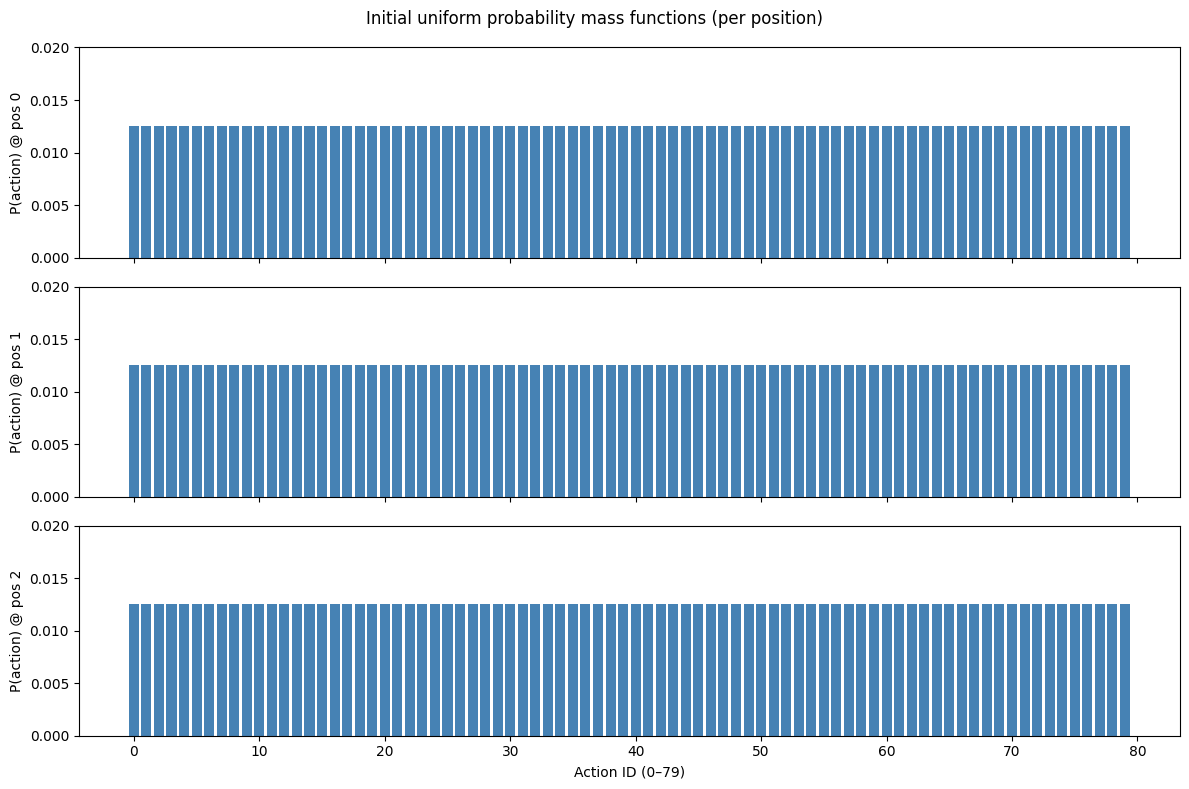

In [3]:

n_actions = bf["n_actions"]   # 80
positions = [0, 1, 2]

# Uniform PMF for each position
pmfs = {pos: np.ones(n_actions) / n_actions for pos in positions}

# Plot
fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

for pos, ax in zip(positions, axes):
    ax.bar(np.arange(n_actions), pmfs[pos], color="steelblue")
    ax.set_ylabel(f"P(action) @ pos {pos}")
    ax.set_ylim(0, 0.02)  # ~1/80 = 0.0125
axes[-1].set_xlabel("Action ID (0–79)")
fig.suptitle("Initial uniform probability mass functions (per position)")
plt.tight_layout()
plt.show()

### Round 1 

In [12]:
sampled = df.groupby("position", group_keys=False).apply(lambda x: x.sample(1, random_state=None))
sampled


,action,position,reward,pscore
253,52,0,0,0.0125
6291,54,1,0,0.0125
4616,39,2,0,0.0125


In [ ]:
# Setup
n_actions = bf["n_actions"]     # K=80
positions = [0, 1, 2]

# Priors: Beta(1,1) everywhere
alpha = {pos: np.ones(n_actions, dtype=float) for pos in positions}
beta  = {pos: np.ones(n_actions, dtype=float) for pos in positions}

# Your single observation
obs_action   = 73
obs_position = 2
obs_reward   = 0  # set to 1 if it was a click

# Update α/β only for that (position, action)
alpha[obs_position][obs_action] += obs_reward
beta[obs_position][obs_action]  += (1 - obs_reward)

def exact_pmf_one_update(K: int, updated_arm: int, reward: int):
    """
    Closed-form TS selection probabilities when all arms start Beta(1,1),
    and exactly one arm has been updated once:
      reward=1 -> that arm is Beta(2,1)
      reward=0 -> that arm is Beta(1,2)
    Returns a length-K vector of probabilities (sums to 1).
    """
    p = np.empty(K, dtype=float)
    if reward == 1:
        # updated arm: 2/(K+1); each other: 1/(K+1)
        p_updated = 2.0 / (K + 1.0)
        p_others  = 1.0 / (K + 1.0)
    else:
        # reward==0: updated arm: 2/(K*(K+1)); others split the remainder
        p_updated = 2.0 / (K * (K + 1.0))
        p_others  = (1.0 - p_updated) / (K - 1.0)
    p.fill(p_others)
    p[updated_arm] = p_updated
    return p

# Build per-position selection probabilities (no Monte Carlo)
pmf_by_pos = {}
for pos in positions:
    if pos == obs_position:
        pmf_by_pos[pos] = exact_pmf_one_update(n_actions, obs_action, obs_reward)
    else:
        # still all Beta(1,1) -> exactly uniform 1/K
        pmf_by_pos[pos] = np.full(n_actions, 1.0 / n_actions, dtype=float)

# Assemble the DataFrame: probabilities + α/β per position
rows = []
for a in range(n_actions):
    row = {"action": a}
    for pos in positions:
        row[f"p_pos{pos}"]      = pmf_by_pos[pos][a]
        row[f"alpha_pos{pos}"]  = alpha[pos][a]
        row[f"beta_pos{pos}"]   = beta[pos][a]
    rows.append(row)

df_probs = pd.DataFrame(rows)
df_probs

,action,p_pos0,alpha_pos0,beta_pos0,p_pos1,alpha_pos1,beta_pos1,p_pos2,alpha_pos2,beta_pos2
0,0,0.0125,1.0,1.0,0.0125,1.0,1.0,0.012654,1.0,1.0
1,1,0.0125,1.0,1.0,0.0125,1.0,1.0,0.012654,1.0,1.0
2,2,0.0125,1.0,1.0,0.0125,1.0,1.0,0.012654,1.0,1.0
3,3,0.0125,1.0,1.0,0.0125,1.0,1.0,0.012654,1.0,1.0
4,4,0.0125,1.0,1.0,0.0125,1.0,1.0,0.012654,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...
75,75,0.0125,1.0,1.0,0.0125,1.0,1.0,0.012654,1.0,1.0
76,76,0.0125,1.0,1.0,0.0125,1.0,1.0,0.012654,1.0,1.0
77,77,0.0125,1.0,1.0,0.0125,1.0,1.0,0.012654,1.0,1.0
78,78,0.0125,1.0,1.0,0.0125,1.0,1.0,0.012654,1.0,1.0


In [10]:
df_probs[df_probs['action'] == obs_action]

,action,p_pos0,alpha_pos0,beta_pos0,p_pos1,alpha_pos1,beta_pos1,p_pos2,alpha_pos2,beta_pos2
73,73,0.0125,1.0,1.0,0.0125,1.0,1.0,0.000309,1.0,2.0


In [14]:
import numpy as np
import pandas as pd

# Setup
n_actions = bf["n_actions"]     # K=80
positions = [0, 1, 2]

# Priors: Beta(1,1) everywhere
alpha = {pos: np.ones(n_actions, dtype=float) for pos in positions}
beta  = {pos: np.ones(n_actions, dtype=float) for pos in positions}

# Your sampled observations (from df.groupby("position").sample(1))
sampled = pd.DataFrame([
    {"action": 52, "position": 0, "reward": 0},
    {"action": 54, "position": 1, "reward": 1},
    {"action": 39, "position": 2, "reward": 0},
])

print("Sampled observations:")
print(sampled)

# Update α/β for each sampled observation
for _, row in sampled.iterrows():
    a_obs = int(row["action"])
    p_obs = int(row["position"])
    r_obs = int(row["reward"])
    alpha[p_obs][a_obs] += r_obs
    beta[p_obs][a_obs]  += (1 - r_obs)

def exact_pmf_one_update(K: int, updated_arm: int, reward: int):
    """
    Closed-form TS selection probabilities when all arms start Beta(1,1),
    and exactly one arm has been updated once:
      reward=1 -> that arm is Beta(2,1)
      reward=0 -> that arm is Beta(1,2)
    Returns a length-K vector of probabilities (sums to 1).
    """
    p = np.empty(K, dtype=float)
    if reward == 1:
        # updated arm: 2/(K+1); each other: 1/(K+1)
        p_updated = 2.0 / (K + 1.0)
        p_others  = 1.0 / (K + 1.0)
    else:
        # reward==0: updated arm: 2/(K*(K+1)); others split the remainder
        p_updated = 2.0 / (K * (K + 1.0))
        p_others  = (1.0 - p_updated) / (K - 1.0)
    p.fill(p_others)
    p[updated_arm] = p_updated
    return p

# Build per-position selection probabilities
pmf_by_pos = {}
for pos in positions:
    obs_row = sampled.loc[sampled["position"] == pos].iloc[0]
    pmf_by_pos[pos] = exact_pmf_one_update(n_actions,
                                           updated_arm=int(obs_row["action"]),
                                           reward=int(obs_row["reward"]))

# Assemble the DataFrame: probabilities + α/β per position
rows = []
for a in range(n_actions):
    row = {"action": a}
    for pos in positions:
        row[f"p_pos{pos}"]      = pmf_by_pos[pos][a]
        row[f"alpha_pos{pos}"]  = alpha[pos][a]
        row[f"beta_pos{pos}"]   = beta[pos][a]
    rows.append(row)

df_probs = pd.DataFrame(rows)

print("\nUpdated probabilities and priors:")
df_probs.loc[[52, 54, 39]]  # show only the updated actions

Sampled observations:
   action  position  reward
0      52         0       0
1      54         1       1
2      39         2       0

Updated probabilities and priors:


,action,p_pos0,alpha_pos0,beta_pos0,p_pos1,alpha_pos1,beta_pos1,p_pos2,alpha_pos2,beta_pos2
52,52,0.000309,1.0,2.0,0.012346,1.0,1.0,0.012654,1.0,1.0
54,54,0.012654,1.0,1.0,0.024691,2.0,1.0,0.012654,1.0,1.0
39,39,0.012654,1.0,1.0,0.012346,1.0,1.0,0.000309,1.0,2.0


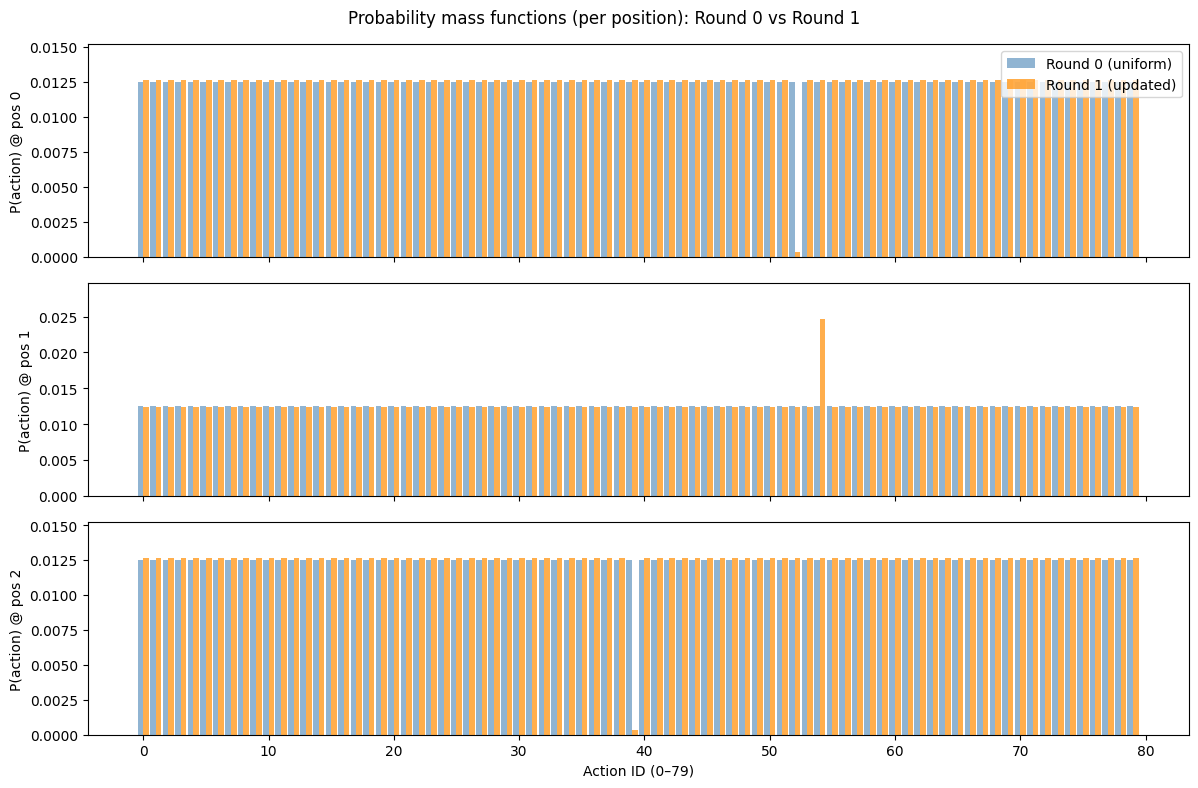

In [ ]:
# round 0 (uniform baseline)
pmfs_round0 = {pos: np.ones(n_actions) / n_actions for pos in positions}

# round 1 (updated probabilities after observations)
pmfs_round1 = pmf_by_pos  # from your earlier update code

# Plot side-by-side bars
fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

bar_width = 0.45

for pos, ax in zip(positions, axes):
    xs = np.arange(n_actions)
    ax.bar(xs - bar_width/2, pmfs_round0[pos], width=bar_width,
           color="steelblue", alpha=0.6, label="Round 0 (uniform)")
    ax.bar(xs + bar_width/2, pmfs_round1[pos], width=bar_width,
           color="darkorange", alpha=0.7, label="Round 1 (updated)")
    ax.set_ylabel(f"P(action) @ pos {pos}")
    ax.set_ylim(0, max(max(pmfs_round0[pos]), max(pmfs_round1[pos])) * 1.2)

axes[-1].set_xlabel("Action ID (0–79)")
fig.suptitle("Probability mass functions (per position): Round 0 vs Round 1")
axes[0].legend(loc="upper right")
plt.tight_layout()
plt.show()